In [2]:
!pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gopalsingh5","key":"4c1f68a628967b1894898c48babd179e"}'}

In [0]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c home-credit-default-risk

  0% 0.00/117k [00:00<?, ?B/s]
100% 117k/117k [00:00<00:00, 45.5MB/s]
  0% 0.00/5.81M [00:00<?, ?B/s]
100% 5.81M/5.81M [00:00<00:00, 94.5MB/s]
 97% 35.0M/36.1M [00:00<00:00, 67.7MB/s]
100% 36.1M/36.1M [00:00<00:00, 120MB/s] 
 92% 34.0M/36.8M [00:00<00:00, 70.2MB/s]
100% 36.8M/36.8M [00:00<00:00, 123MB/s] 
 74% 42.0M/56.8M [00:00<00:00, 58.1MB/s]
100% 56.8M/56.8M [00:00<00:00, 96.7MB/s]
 97% 74.0M/76.3M [00:00<00:00, 54.6MB/s]
100% 76.3M/76.3M [00:00<00:00, 104MB/s] 
 92% 89.0M/96.7M [00:01<00:00, 72.4MB/s]
100% 96.7M/96.7M [00:01<00:00, 94.9MB/s]
 88% 96.0M/109M [00:00<00:00, 104MB/s] 
100% 109M/109M [00:00<00:00, 118MB/s] 
 99% 268M/271M [00:02<00:00, 101MB/s] 
100% 271M/271M [00:02<00:00, 104MB/s]
  0% 0.00/36.5k [00:00<?, ?B/s]
100% 36.5k/36.5k [00:00<00:00, 36.5MB/s]


In [6]:
from zipfile import ZipFile

files = ["POS_CASH_balance.csv.zip", "application_test.csv.zip",
         "application_train.csv.zip", "bureau.csv.zip", "bureau_balance.csv.zip",
         "credit_card_balance.csv.zip", "installments_payments.csv.zip", "previous_application.csv.zip",
         "sample_submission.csv.zip"]


for file_name in files:
  with ZipFile(file_name, 'r') as zip:
    print("Exctracting ==> ", file_name)
    zip.extractall()
    print('Done')

Exctracting ==>  POS_CASH_balance.csv.zip
Done
Exctracting ==>  application_test.csv.zip
Done
Exctracting ==>  application_train.csv.zip
Done
Exctracting ==>  bureau.csv.zip
Done
Exctracting ==>  bureau_balance.csv.zip
Done
Exctracting ==>  credit_card_balance.csv.zip
Done
Exctracting ==>  installments_payments.csv.zip
Done
Exctracting ==>  previous_application.csv.zip
Done
Exctracting ==>  sample_submission.csv.zip
Done


In [0]:
from fastai.tabular import *
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import LabelEncoder

In [0]:
def label_encoder(df):
  lb = LabelEncoder()
  df = df.copy()
  cat_var = df.select_dtypes('object').columns.tolist()
  for col in cat_var:
    # Changing categorical variable to a string variable for better runtime
    df[col] = lb.fit_transform(df[col].astype('str'))
  return df

def fill_na(df):
  df = df.copy()
  num_features = df.select_dtypes(['float64', 'int64']).columns.tolist()
  df[num_features] = df[num_features].fillna(-999)
  return df


In [0]:
bureau = (pd.read_csv("bureau.csv").pipe(label_encoder))
cred_card_bal = (pd.read_csv("credit_card_balance.csv").pipe(label_encoder))
pos_cash_bal = (pd.read_csv("POS_CASH_balance.csv").pipe(label_encoder))
prev = (pd.read_csv("previous_application.csv").pipe(label_encoder))

In [0]:
label_1 = [s+'_'+l for s in bureau.columns.tolist() if s!='SK_ID_CURR' for l in ['mean', 'count', 'median', 'max']]
avg_bureau = bureau.groupby('SK_ID_CURR').agg(['mean', 'count', 'median', 'max']).reset_index()
avg_bureau.columns = ['SK_ID_CURR'] + label_1

label_2 = [s+'_'+l for s in cred_card_bal.columns.tolist() if s!='SK_ID_CURR' for l in ['mean', 'count', 'median', 'max']]
avg_cred_card_bal = cred_card_bal.groupby('SK_ID_CURR').agg(['mean', 'count', 'median', 'max']).reset_index()
avg_cred_card_bal.columns = ['SK_ID_CURR'] + label_2

label_3 = [s+'_'+l for s in pos_cash_bal.columns.tolist() if s!='SK_ID_CURR' for l in ['mean', 'count', 'median', 'max']]
avg_pos_cash_bal = pos_cash_bal.groupby('SK_ID_CURR').agg(['mean', 'count', 'median', 'max']).reset_index()
avg_pos_cash_bal.columns = ['SK_ID_CURR'] + label_3

label_4 = [s+'_'+l for s in prev.columns.tolist() if s!='SK_ID_CURR' for l in ['mean', 'count', 'median', 'max']]
avg_prev = prev.groupby('SK_ID_CURR').agg(['mean', 'count', 'median', 'max']).reset_index()
avg_prev.columns = ['SK_ID_CURR'] + label_4

In [5]:
del(label_1, label_2, label_3, label_4)
gc.collect()

63

In [0]:
train_df = pd.read_csv("application_train.csv")
test_df = pd.read_csv("application_test.csv")

In [0]:

train_data = (train_df
             .pipe(label_encoder)
             .pipe(fill_na)
             .merge(avg_bureau, on='SK_ID_CURR', how='left')
             .merge(avg_cred_card_bal, on='SK_ID_CURR', how='left')
             .merge(avg_pos_cash_bal, on='SK_ID_CURR', how='left')
             .merge(avg_prev, on='SK_ID_CURR', how='left'))

test_data = (test_df
             .pipe(label_encoder)
             .pipe(fill_na)
             .merge(avg_bureau, on='SK_ID_CURR', how='left')
             .merge(avg_cred_card_bal, on='SK_ID_CURR', how='left')
             .merge(avg_pos_cash_bal, on='SK_ID_CURR', how='left')
             .merge(avg_prev, on='SK_ID_CURR', how='left'))

In [8]:
del(train_df, test_df, bureau,cred_card_bal,pos_cash_bal,prev, avg_prev,avg_bureau,avg_cred_card_bal,avg_pos_cash_bal)
gc.collect()

112

In [0]:
dep_var = 'TARGET'

In [0]:
# cont_list, _ = cont_cat_split(df=train_data, max_card=20, dep_var='TARGET')
cat_list = [col for col in train_data if train_data[col].dtype.name != 'float64' and train_data[col].dtype.name != 'float32' and len(train_data[col].unique()) < 50]
cat_list.remove('TARGET')

In [0]:
path = Path('.')
procs = [FillMissing, Categorify, Normalize]
test = TabularList.from_df(test_data.copy(), path=path, cat_names=cat_list)
# test = TabularList.from_df(data_merged.iloc[0:48744].copy(), path=path, cat_names=cat_list)

In [0]:
data_fastai = (TabularList.from_df(train_data, cat_names=cat_list, procs=procs)
                           .split_by_idx(list(range(500,1000)))
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

In [13]:
data_fastai.show_batch(rows=10)

NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,target
0,0,0,1,0,6,7,4,1,1,1,1,0,1,1,0,18,3,3,6,12,0,0,0,0,0,0,0,1,7,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,1,0,0,3,4,0,1,1,0,0,1,0,0,18,2,2,6,13,0,0,0,0,0,0,0,0,7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1,1,1,0,6,7,4,3,1,1,1,0,1,0,1,8,2,2,6,8,0,0,0,0,0,0,0,0,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,1,0,6,7,4,1,1,1,1,1,1,1,0,11,2,2,0,10,0,0,0,0,0,0,0,1,7,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,1,0,6,7,4,3,1,1,1,0,1,1,0,10,1,1,6,15,0,0,0,0,0,0,4,0,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,1,1,1,6,7,4,1,1,1,1,1,1,1,0,6,2,2,1,10,0,0,0,0,1,1,0,1,7,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,1,0,6,3,4,1,1,1,0,0,1,0,0,18,2,2,3,16,0,0,0,0,0,0,4,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,1,1,1,6,1,1,1,1,1,1,0,1,0,0,10,2,2,5,15,0,0,0,0,0,0,3,0,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,1,2,1,5,1,1,0,1,0,0,14,2,2,1,8,0,0,0,0,0,0,0,1,7,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1,1,1,0,6,1,4,1,2,1,1,0,1,0,1,3,1,1,4,14,0,0,0,0,0,0,3,0,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
model = tabular_learner(data_fastai, layers=[200, 100], metrics=[accuracy, AUROC()])

In [15]:
model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


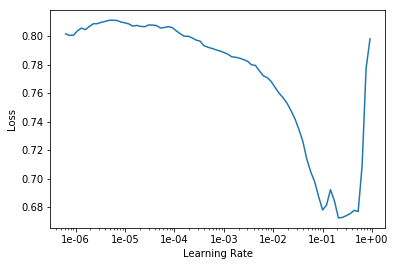

In [17]:
model.recorder.plot()

In [18]:
lr =1e-2
model.fit(1, lr)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.260894,0.272052,0.926000,0.617936,01:21


In [0]:
model.save('61%_auroc')

In [0]:
model.unfreeze()

In [21]:
model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


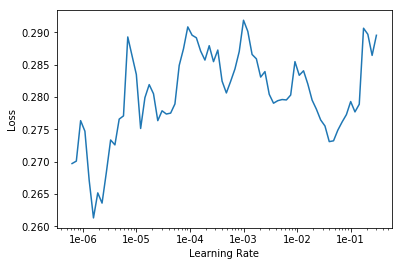

In [22]:
model.recorder.plot()

In [23]:
model.fit(2, lr/400)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.264745,0.262659,0.924000,0.616619,01:24
1,0.273560,0.265971,0.926000,0.617098,01:22


In [0]:
preds, y = model.get_preds(ds_type=DatasetType.Test)
probs = preds.numpy()[:, 0]

In [0]:
submissions = pd.read_csv("sample_submission.csv")
submissions['TARGET'] = probs.copy()
submissions.to_csv('fast_submission.csv', index=False)

In [26]:
!kaggle competitions submit -c home-credit-default-risk -f fast_submission.csv -m "Message"

100% 825k/825k [00:04<00:00, 189kB/s]
Successfully submitted to Home Credit Default Risk

## 50% with fastai on this competition.

## Using LightGBM 

In [0]:
## Merging the entire data
data = (train_df.drop(labels=['TARGET'], axis=1).append(test_df)
             .pipe(label_encoder)
             .pipe(fill_na)
             .merge(avg_bureau, on='SK_ID_CURR', how='left')
             .merge(avg_cred_card_bal, on='SK_ID_CURR', how='left')
             .merge(avg_pos_cash_bal, on='SK_ID_CURR', how='left')
             .merge(avg_prev, on='SK_ID_CURR', how='left'))

In [0]:
y = train_df.TARGET.copy()
idx = train_df.shape[0]

In [9]:
del(train_df, test_df, bureau,cred_card_bal,pos_cash_bal,prev, avg_prev,avg_bureau,avg_cred_card_bal,avg_pos_cash_bal)
gc.collect()

133

In [0]:
data.drop(labels=['SK_ID_CURR'], axis=1, inplace=True)
train = data.iloc[:idx, :].copy()
test = data.iloc[idx:, :].copy()

del(data)

In [0]:
params = {'objective' : 'binary',
          'boosting_type': 'gbdt',
          'metric' : 'auc',
          'nthread' : 4,
          'shrinkage_rate':0.025,
          'max_depth':8,
          'min_data_in_leaf':100,
          'min_child_weight': 2,
          'bagging_fraction':0.75,
          'feature_fraction':0.75,
          'min_split_gain':.01,
          'lambda_l1':1,
          'lambda_l2':1,
          'num_leaves':36}

In [14]:
%%time
from sklearn.model_selection import KFold
import lightgbm as gbm
from sklearn.metrics import roc_auc_score

folds = KFold(n_splits=5, shuffle=True, random_state=123)

train_preds = np.zeros(train.shape[0])
test_preds = np.zeros(test.shape[0])
feature_imps = pd.DataFrame()
feats = [f for f in train.columns if f not in ['SK_ID_CURR']]

for n_fold, (train_idx, val_idx) in enumerate(folds.split(train)):
  dtrain = gbm.Dataset(train.iloc[train_idx], y.iloc[train_idx])
  dval = gbm.Dataset(train.iloc[val_idx], y.iloc[val_idx])
  m_gbm = gbm.train(params=params, train_set=dtrain, num_boost_round=3000, verbose_eval=1000, valid_sets=[dtrain, dval], valid_names=['train', 'valid'])
  train_preds[val_idx] = m_gbm.predict(train.iloc[val_idx])
  test_preds += m_gbm.predict(test)/folds.n_splits
  fold_importance_df = pd.DataFrame()
  fold_importance_df['feature'] = feats
  fold_importance_df['importance'] = m_gbm.feature_importance()
  fold_importance_df['fold'] = n_fold + 1
  feature_imps = pd.concat([feature_imps, fold_importance_df], axis=0)
  print("{} Fold ===> AUC {}".format(n_fold+1, roc_auc_score(y.iloc[val_idx], train_preds[val_idx])))
  del dtrain, dval
  gc.collect()

print('Final AUC score {}'.format(roc_auc_score(y, train_preds)))

[1000]	train's auc: 0.878283	valid's auc: 0.784593
[2000]	train's auc: 0.931744	valid's auc: 0.783793
[3000]	train's auc: 0.962291	valid's auc: 0.781945
1 Fold ===> AUC 0.7819453267445927
[1000]	train's auc: 0.877603	valid's auc: 0.782658
[2000]	train's auc: 0.930663	valid's auc: 0.782609
[3000]	train's auc: 0.96102	valid's auc: 0.781734
2 Fold ===> AUC 0.7817340373297111
[1000]	train's auc: 0.878621	valid's auc: 0.780871
[2000]	train's auc: 0.931352	valid's auc: 0.780228
[3000]	train's auc: 0.961371	valid's auc: 0.778518
3 Fold ===> AUC 0.7785183105270186
[1000]	train's auc: 0.87704	valid's auc: 0.784186
[2000]	train's auc: 0.929962	valid's auc: 0.784067
[3000]	train's auc: 0.960946	valid's auc: 0.783073
4 Fold ===> AUC 0.7830727599990155
[1000]	train's auc: 0.877823	valid's auc: 0.785349
[2000]	train's auc: 0.930717	valid's auc: 0.784579
[3000]	train's auc: 0.961103	valid's auc: 0.783669
5 Fold ===> AUC 0.7836688727601995
Final AUC score 0.7817673379362363
CPU times: user 3h 23min 17

In [0]:
submissions = pd.read_csv("sample_submission.csv")
submissions['TARGET'] = test_preds.copy()
submissions.to_csv('Target_with_gbm_samples.csv', index=False)

In [16]:
!kaggle competitions submit -c home-credit-default-risk -f Target_with_gbm_samples.csv -m "Message"

100% 1.27M/1.27M [00:04<00:00, 311kB/s]
Successfully submitted to Home Credit Default Risk

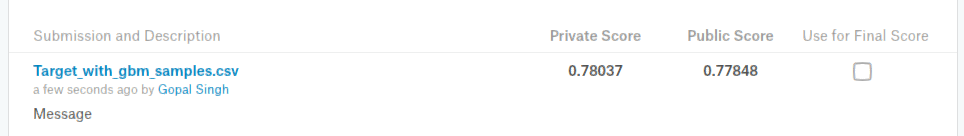

In [17]:
from IPython.display import Image
Image("kaggle.png")

# THE END :)